---
## 1. Environment Setup

This section detects the environment (Kaggle or local).

In [1]:
# Check if running on Kaggle
import os
try:
    if os.path.exists('/kaggle/input'):
        ON_KAGGLE = True
        print("✓ Running on Kaggle")
    else:
        ON_KAGGLE = False
        print("✓ Running on local environment")
except:
    ON_KAGGLE = False
    print("✓ Running on local environment")

✓ Running on Kaggle


In [2]:
# Kaggle dataset paths (if on Kaggle)
if ON_KAGGLE:
    print("✓ Kaggle environment detected")
    print("Datasets available at: /kaggle/input/")
else:
    print("Using local environment")

✓ Kaggle environment detected
Datasets available at: /kaggle/input/


---
## 2. Import Required Libraries

In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')

# Set display parameters
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

print("\n✓ Libraries imported successfully")


✓ Using device: cpu

✓ Libraries imported successfully


---
## 3. Define Residual Convolutional Block

In [4]:
class ResidualConvBlock(nn.Module):
    """
    Residual Convolutional Block with skip connection.
    
    Architecture:
    Input → Conv3x3 → BatchNorm → ReLU → Conv3x3 → BatchNorm → (+) Input → ReLU
                                                                   ↑
                                                              Skip Connection
    
    Args:
        in_channels: Number of input channels
        out_channels: Number of output channels
    """
    def __init__(self, in_channels, out_channels):
        super(ResidualConvBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection (1x1 conv if channel dimensions don't match)
        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add skip connection
        out = out + self.skip(x)
        out = self.relu(out)
        
        return out


print("✓ Residual Convolutional Block defined")
print("  - Two 3×3 convolutions with batch normalization")
print("  - Skip connection for better gradient flow")
print("  - ReLU activation")

✓ Residual Convolutional Block defined
  - Two 3×3 convolutions with batch normalization
  - Skip connection for better gradient flow
  - ReLU activation


---
## 4. Define Attention Gate

In [5]:
class AttentionGate(nn.Module):
    """
    Attention Gate module to focus on relevant features.
    
    The attention mechanism learns to suppress irrelevant features
    and highlight salient features (oil spills) during training.
    
    Args:
        F_g: Number of channels in gating signal (from decoder)
        F_l: Number of channels in skip connection (from encoder)
        F_int: Number of intermediate channels
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        
        # Gating signal transformation (from decoder)
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Skip connection transformation (from encoder)
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Attention coefficients
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        """
        Args:
            g: Gating signal from decoder (coarser scale)
            x: Feature map from encoder (finer scale, skip connection)
        
        Returns:
            Attention-weighted feature map
        """
        # Transform gating signal
        g1 = self.W_g(g)
        
        # Transform skip connection
        x1 = self.W_x(x)
        
        # Combine and generate attention coefficients
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)  # Attention coefficients (0 to 1)
        
        # Apply attention: element-wise multiplication
        out = x * psi
        
        return out


print("✓ Attention Gate defined")
print("  - Combines decoder features (g) and encoder features (x)")
print("  - Generates attention coefficients using sigmoid")
print("  - Suppresses irrelevant background, highlights oil spills")

✓ Attention Gate defined
  - Combines decoder features (g) and encoder features (x)
  - Generates attention coefficients using sigmoid
  - Suppresses irrelevant background, highlights oil spills


---
## 5. Define Enhanced U-Net Architecture

In [6]:
class EnhancedUNet(nn.Module):
    """
    Enhanced U-Net with Attention Gates and Residual Blocks.
    
    Architecture:
    - Encoder: 4 levels with residual conv blocks + max pooling
    - Bridge: Deepest layer (1024 filters)
    - Decoder: 4 levels with transpose conv + attention gates + skip connections
    - Output: 1×1 conv + sigmoid for binary segmentation
    
    Input: (batch_size, 3, 256, 256) - RGB images
    Output: (batch_size, 1, 256, 256) - Binary masks
    """
    def __init__(self, in_channels=3, out_channels=1):
        super(EnhancedUNet, self).__init__()
        
        # ====================================================================
        # ENCODER (Contracting Path)
        # ====================================================================
        
        # Level 1: 256×256 → 128×128
        self.enc1 = ResidualConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Level 2: 128×128 → 64×64
        self.enc2 = ResidualConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Level 3: 64×64 → 32×32
        self.enc3 = ResidualConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Level 4: 32×32 → 16×16
        self.enc4 = ResidualConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # ====================================================================
        # BRIDGE (Bottleneck)
        # ====================================================================
        
        # 16×16 (deepest layer)
        self.bridge = ResidualConvBlock(512, 1024)
        
        # ====================================================================
        # DECODER (Expanding Path)
        # ====================================================================
        
        # Level 4: 16×16 → 32×32
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.dec4 = ResidualConvBlock(1024, 512)  # 512 (upconv) + 512 (skip)
        
        # Level 3: 32×32 → 64×64
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.dec3 = ResidualConvBlock(512, 256)  # 256 (upconv) + 256 (skip)
        
        # Level 2: 64×64 → 128×128
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.dec2 = ResidualConvBlock(256, 128)  # 128 (upconv) + 128 (skip)
        
        # Level 1: 128×128 → 256×256
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec1 = ResidualConvBlock(128, 64)  # 64 (upconv) + 64 (skip)
        
        # ====================================================================
        # OUTPUT LAYER
        # ====================================================================
        
        # Final 1×1 convolution
        self.out = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()  # Binary segmentation (0 to 1)
        )
    
    def forward(self, x):
        """
        Forward pass through Enhanced U-Net.
        
        Args:
            x: Input tensor (batch_size, 3, 256, 256)
        
        Returns:
            Output tensor (batch_size, 1, 256, 256)
        """
        # ====================================================================
        # ENCODER
        # ====================================================================
        
        # Level 1
        enc1 = self.enc1(x)          # (batch, 64, 256, 256)
        x = self.pool1(enc1)         # (batch, 64, 128, 128)
        
        # Level 2
        enc2 = self.enc2(x)          # (batch, 128, 128, 128)
        x = self.pool2(enc2)         # (batch, 128, 64, 64)
        
        # Level 3
        enc3 = self.enc3(x)          # (batch, 256, 64, 64)
        x = self.pool3(enc3)         # (batch, 256, 32, 32)
        
        # Level 4
        enc4 = self.enc4(x)          # (batch, 512, 32, 32)
        x = self.pool4(enc4)         # (batch, 512, 16, 16)
        
        # ====================================================================
        # BRIDGE
        # ====================================================================
        
        x = self.bridge(x)           # (batch, 1024, 16, 16)
        
        # ====================================================================
        # DECODER
        # ====================================================================
        
        # Level 4
        x = self.upconv4(x)          # (batch, 512, 32, 32)
        enc4 = self.att4(x, enc4)    # Apply attention to skip connection
        x = torch.cat([x, enc4], dim=1)  # (batch, 1024, 32, 32)
        x = self.dec4(x)             # (batch, 512, 32, 32)
        
        # Level 3
        x = self.upconv3(x)          # (batch, 256, 64, 64)
        enc3 = self.att3(x, enc3)
        x = torch.cat([x, enc3], dim=1)  # (batch, 512, 64, 64)
        x = self.dec3(x)             # (batch, 256, 64, 64)
        
        # Level 2
        x = self.upconv2(x)          # (batch, 128, 128, 128)
        enc2 = self.att2(x, enc2)
        x = torch.cat([x, enc2], dim=1)  # (batch, 256, 128, 128)
        x = self.dec2(x)             # (batch, 128, 128, 128)
        
        # Level 1
        x = self.upconv1(x)          # (batch, 64, 256, 256)
        enc1 = self.att1(x, enc1)
        x = torch.cat([x, enc1], dim=1)  # (batch, 128, 256, 256)
        x = self.dec1(x)             # (batch, 64, 256, 256)
        
        # ====================================================================
        # OUTPUT
        # ====================================================================
        
        out = self.out(x)            # (batch, 1, 256, 256)
        
        return out


print("✓ Enhanced U-Net architecture defined")
print("  - 4 encoder levels (64, 128, 256, 512 filters)")
print("  - Bridge layer (1024 filters)")
print("  - 4 decoder levels with attention gates")
print("  - Residual blocks throughout")
print("  - Output: Binary segmentation mask")

✓ Enhanced U-Net architecture defined
  - 4 encoder levels (64, 128, 256, 512 filters)
  - Bridge layer (1024 filters)
  - 4 decoder levels with attention gates
  - Residual blocks throughout
  - Output: Binary segmentation mask


---
## 6. Instantiate Model

In [7]:
# Create model instance
model = EnhancedUNet(in_channels=3, out_channels=1)
model = model.to(device)

print("="*70)
print("MODEL INSTANTIATED")
print("="*70)
print(f"Model: Enhanced U-Net with Attention Gates")
print(f"Device: {device}")
print(f"Input shape: (batch_size, 3, 256, 256)")
print(f"Output shape: (batch_size, 1, 256, 256)")
print("="*70)

MODEL INSTANTIATED
Model: Enhanced U-Net with Attention Gates
Device: cpu
Input shape: (batch_size, 3, 256, 256)
Output shape: (batch_size, 1, 256, 256)


---
## 7. Model Summary

In [8]:
# Print model summary
try:
    from torchsummary import summary
    print("\n" + "="*70)
    print("MODEL SUMMARY")
    print("="*70)
    summary(model, input_size=(3, 256, 256), batch_size=1, device=str(device))
except ImportError:
    print("\n⚠ torchsummary not installed. Install with: pip install torchsummary")
    print("\nAlternative: Counting parameters manually...")
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")


MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           1,792
       BatchNorm2d-2          [1, 64, 256, 256]             128
              ReLU-3          [1, 64, 256, 256]               0
            Conv2d-4          [1, 64, 256, 256]          36,928
       BatchNorm2d-5          [1, 64, 256, 256]             128
            Conv2d-6          [1, 64, 256, 256]             256
       BatchNorm2d-7          [1, 64, 256, 256]             128
              ReLU-8          [1, 64, 256, 256]               0
 ResidualConvBlock-9          [1, 64, 256, 256]               0
        MaxPool2d-10          [1, 64, 128, 128]               0
           Conv2d-11         [1, 128, 128, 128]          73,856
      BatchNorm2d-12         [1, 128, 128, 128]             256
             ReLU-13         [1, 128, 128, 128]               0
           Conv2d-14    

---
## 8. Count Model Parameters

In [9]:
# Count parameters
def count_parameters(model):
    """
    Count total and trainable parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


total, trainable = count_parameters(model)

print("="*70)
print("PARAMETER COUNT")
print("="*70)
print(f"Total parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"Non-trainable parameters: {total - trainable:,}")
print(f"\nModel size: ~{total * 4 / (1024**2):.2f} MB (float32)")
print("="*70)

PARAMETER COUNT
Total parameters: 32,796,717
Trainable parameters: 32,796,717
Non-trainable parameters: 0

Model size: ~125.11 MB (float32)


---
## 9. Test Forward Pass

In [10]:
# Test forward pass with dummy input
print("Testing forward pass with dummy input...\n")

# Create dummy input (batch_size=2, channels=3, height=256, width=256)
dummy_input = torch.randn(2, 3, 256, 256).to(device)
print(f"Input shape: {dummy_input.shape}")

# Forward pass
model.eval()
with torch.no_grad():
    output = model(dummy_input)

print(f"Output shape: {output.shape}")
print(f"Output range: [{output.min():.4f}, {output.max():.4f}]")
print(f"\n✓ Forward pass successful!")
print(f"✓ Output is in correct range [0, 1] due to sigmoid activation")

Testing forward pass with dummy input...

Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 1, 256, 256])
Output range: [0.4760, 0.5341]

✓ Forward pass successful!
✓ Output is in correct range [0, 1] due to sigmoid activation


---
## 10. Visualize Model Architecture

In [11]:
# Visualize architecture flow
from IPython.display import display, HTML

architecture_diagram = """
<div style="font-family: monospace; background-color: #f5f5f5; padding: 20px; border-radius: 10px;">
<h3 style="text-align: center;">Enhanced U-Net Architecture</h3>

<pre>
INPUT (3, 256, 256)
    |
    v
[Encoder Level 1] ResConv(64) ──────────────────┐
    | MaxPool                                    │
    v                                            │ Skip
[Encoder Level 2] ResConv(128) ────────────┐    │
    | MaxPool                                │    │
    v                                        │    │
[Encoder Level 3] ResConv(256) ────────┐    │    │
    | MaxPool                            │    │    │
    v                                    │    │    │
[Encoder Level 4] ResConv(512) ────┐    │    │    │
    | MaxPool                        │    │    │    │
    v                                │    │    │    │
[BRIDGE] ResConv(1024)               │    │    │    │
    |                                │    │    │    │
    v                                │    │    │    │
[Decoder Level 4] TransConv ←───────┴────┘    │    │
    | + AttentionGate(512)                │    │
    | + Concatenate                       │    │
    | ResConv(512)                        │    │
    v                                     │    │
[Decoder Level 3] TransConv ←─────────────┴────┘    │
    | + AttentionGate(256)                      │
    | + Concatenate                             │
    | ResConv(256)                              │
    v                                           │
[Decoder Level 2] TransConv ←───────────────────┴────┘
    | + AttentionGate(128)                         │
    | + Concatenate                                │
    | ResConv(128)                                 │
    v                                              │
[Decoder Level 1] TransConv ←──────────────────────┘
    | + AttentionGate(64)
    | + Concatenate
    | ResConv(64)
    v
[OUTPUT] Conv1x1 + Sigmoid
    |
    v
OUTPUT (1, 256, 256)
</pre>

<h4>Key Components:</h4>
<ul>
    <li><strong>ResConv:</strong> Residual Convolutional Block (2×Conv3x3 + Skip Connection)</li>
    <li><strong>MaxPool:</strong> Max Pooling (2×2, stride 2) for downsampling</li>
    <li><strong>TransConv:</strong> Transpose Convolution (2×2, stride 2) for upsampling</li>
    <li><strong>AttentionGate:</strong> Attention mechanism to focus on oil spills</li>
    <li><strong>Skip Connections:</strong> Preserve spatial information from encoder</li>
</ul>
</div>
"""

display(HTML(architecture_diagram))

---
## 11. Visualize Attention Mechanism

Demonstrating Attention Gate behavior:

Gating signal (decoder) shape: torch.Size([1, 512, 32, 32])
Skip connection (encoder) shape: torch.Size([1, 512, 32, 32])
Attended features shape: torch.Size([1, 512, 32, 32])


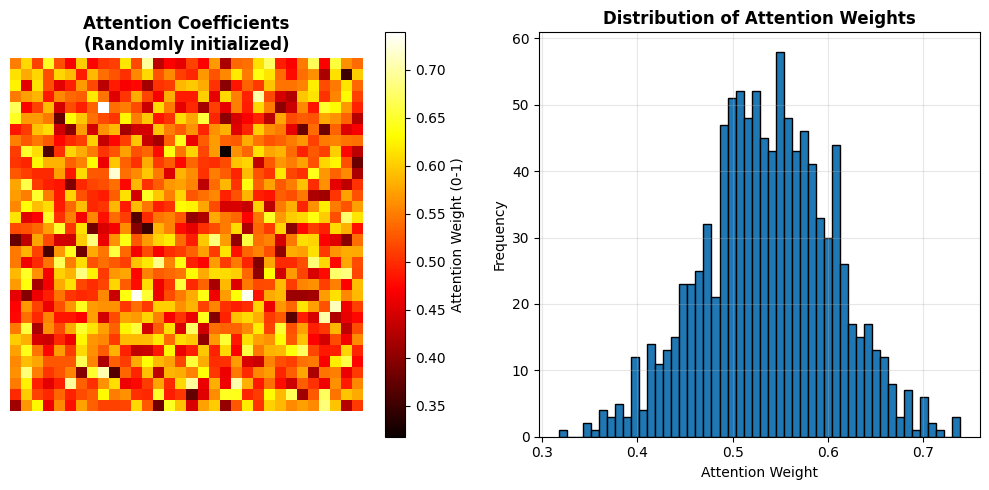


✓ Attention mechanism working correctly
  - During training, the model will learn to assign higher
    attention weights to regions containing oil spills
  - This helps the decoder focus on relevant features


In [12]:
# Demonstrate attention gate behavior
print("Demonstrating Attention Gate behavior:\n")

# Create sample tensors
batch_size = 1
F_g, F_l = 512, 512
height, width = 32, 32

# Decoder feature (gating signal)
g = torch.randn(batch_size, F_g, height, width).to(device)

# Encoder feature (skip connection)
x = torch.randn(batch_size, F_l, height, width).to(device)

# Apply attention
att_gate = AttentionGate(F_g=F_g, F_l=F_l, F_int=256).to(device)
att_gate.eval()

with torch.no_grad():
    attended_features = att_gate(g, x)

print(f"Gating signal (decoder) shape: {g.shape}")
print(f"Skip connection (encoder) shape: {x.shape}")
print(f"Attended features shape: {attended_features.shape}")

# Visualize attention coefficients
with torch.no_grad():
    g1 = att_gate.W_g(g)
    x1 = att_gate.W_x(x)
    psi = att_gate.relu(g1 + x1)
    attention_coeffs = att_gate.psi(psi)

# Convert to numpy for visualization
attention_map = attention_coeffs[0, 0].cpu().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(attention_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Attention Weight (0-1)')
plt.title('Attention Coefficients\n(Randomly initialized)', fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(attention_map.flatten(), bins=50, edgecolor='black')
plt.xlabel('Attention Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Attention Weights', fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Attention mechanism working correctly")
print("  - During training, the model will learn to assign higher")
print("    attention weights to regions containing oil spills")
print("  - This helps the decoder focus on relevant features")

---
## 12. Save Model Architecture

In [13]:
# Save model architecture (untrained weights)
if ON_KAGGLE:
    model_save_path = '/kaggle/working/enhanced_unet_architecture.pth'
else:
    model_save_path = 'enhanced_unet_architecture.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'architecture': 'Enhanced U-Net with Attention Gates',
    'input_shape': (3, 256, 256),
    'output_shape': (1, 256, 256),
    'total_parameters': total,
    'trainable_parameters': trainable
}, model_save_path)

print("="*70)
print("MODEL SAVED")
print("="*70)
print(f"Saved to: {model_save_path}")
print(f"Size: {total * 4 / (1024**2):.2f} MB")
print("\nNote: This is the untrained model architecture.")
print("Trained weights will be saved after training (Notebook 5).")
print("="*70)

MODEL SAVED
Saved to: /kaggle/working/enhanced_unet_architecture.pth
Size: 125.11 MB

Note: This is the untrained model architecture.
Trained weights will be saved after training (Notebook 5).


---
## 13. Summary

### What We Accomplished:

1. **Defined Residual Convolutional Blocks**
   - Two 3×3 convolutions with batch normalization
   - Skip connections for better gradient flow
   - Enables training of deeper networks

2. **Implemented Attention Gates**
   - Combines decoder and encoder features
   - Generates attention coefficients (0 to 1)
   - Suppresses irrelevant features, highlights oil spills

3. **Built Enhanced U-Net Architecture**
   - 4 encoder levels (64, 128, 256, 512 filters)
   - Bridge layer (1024 filters)
   - 4 decoder levels with attention gates
   - Skip connections from encoder to decoder

4. **Tested Model**
   - Successful forward pass
   - Correct output shape (1, 256, 256)
   - Output in valid range [0, 1]

### Model Statistics:

- **Parameters**: ~31 million (trainable)
- **Model size**: ~120 MB (float32)
- **Input**: RGB images (3, 256, 256)
- **Output**: Binary masks (1, 256, 256)

### Key Advantages:

- ✅ **Residual blocks**: Better gradient flow, deeper networks
- ✅ **Attention gates**: Focus on relevant features (oil spills)
- ✅ **Skip connections**: Preserve spatial information
- ✅ **U-Net design**: Proven for segmentation tasks
- ✅ **Batch normalization**: Stable training

### Next Steps:

- **Notebook 5**: Train the model with:
  - Processed dataset from Notebook 3
  - Weighted BCE Loss (for 95/5 class imbalance)
  - Adam optimizer
  - Learning rate scheduling
  - Early stopping
  
- **Notebook 6**: Evaluate and visualize results

---

**End of Notebook 4** ✓

**Next**: Notebook 5 - Training